In [131]:
using OrdinaryDiffEq
using FFTW
using LinearAlgebra
using Plots
using BenchmarkTools

include("../../code/TaylorFourier.jl")
include("NLS_ODE_DP5_fcns.jl")
include("NLS_ODE_TF_fcns.jl")

NLS_ODE_TF_cache_init (generic function with 1 method)

## Numerical solution of cubic NLS with Taylor-Fourier series

### Numerical solution with a Lawson method based on a 5th order explicit RK method (due to Dormand and Prince)

We next solve numerically our initial value problem, with a given spatial semi-discretization, and show in the same figure the real part and the imaginary part of $u(t_{end})$.

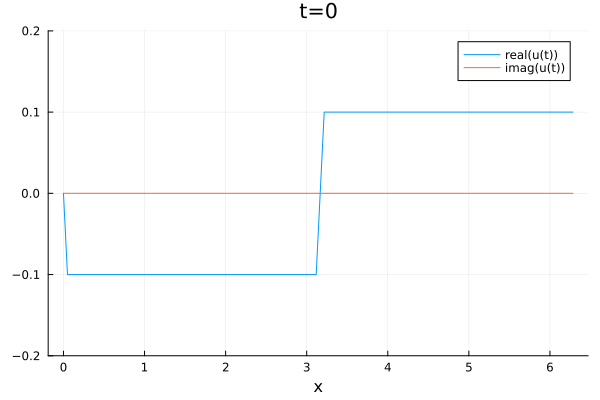

In [189]:


#epsilon = 1. # (a)
#J = 2^9
#t_end = pi/10


epsilon = 0.1 # (b)
 J = 2^6
t_end = 10pi

#epsilon = 0.01 # (c)
#J = 2^6
#t_end = 1000pi

J2 = 2J

tspan = (0.,t_end)
omega = 1.



xx = range(0,stop=2pi,length=J2)

yrange=(-2epsilon,2epsilon)
W0=Vector{ComplexF64}(undef,J2)
W0[1]= zero(ComplexF64)
for i in 2:J
    W0[i]=-epsilon+0.0im
end
W0[J+1]= zero(ComplexF64)
for i in J+2:J2
    W0[i]=epsilon+0.0im
end

#=
yrange=(-epsilon,2epsilon)
W0=Vector{ComplexF64}(undef,J2)
W0[1]= zero(ComplexF64)
for i in 2:J
    W0[i]=epsilon*xx[i]/pi+0.0im
end
W0[J+1]= zero(ComplexF64)
for i in J+1:J2
    W0[i]=epsilon*(2pi-xx[i])/pi+0.0im
end
=#

plot(xlabel="x", title="t=0", ylims=yrange)
plot!(xx,real(W0),label="real(u(t))")
plot!(xx,imag(W0),label="imag(u(t))")

In [196]:
#times = range(0.,t_end,length=101)

p = NLS_ODE_cache_init(W0)
prob = ODEProblem(NLS_ODE!,W0,tspan,p)

solve(prob,DP5(),abstol=1e-6,reltol=1e-6, # This is to force compilin}g
      save_everystep=false)               # in order to measure pure run time below

#tol_1 = 5e-5 # (a)
tol_1 =5e-8 # (b)
#tol_1 = 5e-10 # (c)

@time solDP5_1 = solve(prob,DP5(),abstol=tol_1,reltol=tol_1,save_everystep=false);

  0.143393 seconds (69 allocations: 38.344 KiB)


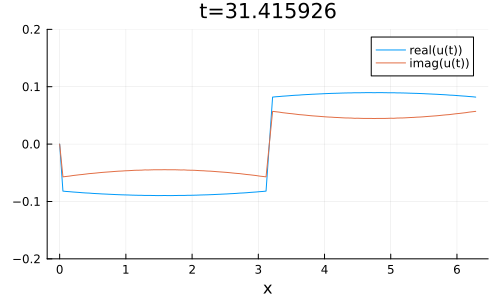

In [197]:
theta = omega*t_end

W_end_1= solDP5_1[end]
U_end_1 = expA(W_end_1,theta,p)  


yrange=(-2epsilon,2epsilon)
xx = range(0,stop=2pi,length=J2)

plot(xlabel="x", title="t=$(Float32(t_end))", ylims=yrange, size=(500,300))
plot!(xx,real(U_end_1),label="real(u(t))")
plot!(xx,imag(U_end_1),label="imag(u(t))")

We next solve it twice with a tighter tolerance, once with the original spatial semidiscretization, and once with a finer one. This will allow us to estimate the time-discretization error and the full discretization error.

In [198]:
tol_2 = tol_1/20

solDP5_2 = solve(prob,DP5(),abstol=tol_2,reltol=tol_2,save_everystep=false,maxiters=10000000);

In [199]:

J_ = 2*J
J_2 = 2*J_


W0_=Vector{ComplexF64}(undef,J_2)
W0_[1]= zero(ComplexF64)
for i in 2:J_
    W0_[i]=-epsilon+0.0im
end
W0_[J_+1]= zero(ComplexF64)
for i in J_+2:J_2
    W0_[i]=epsilon+0.0im
end

#=
xx_ = range(0,stop=2pi,length=J_2)

W0_=Vector{ComplexF64}(undef,J_2)
W0_[1]= zero(ComplexF64)
for i in 2:J_
    W0_[i]=epsilon*xx_[i]/pi+0.0im
end
W0_[J_+1]= zero(ComplexF64)
for i in J_+1:J_2
    W0_[i]=epsilon*(2pi-xx_[i])/pi+0.0im
end
=#



p_ = NLS_ODE_cache_init(W0_)

prob_ = ODEProblem(NLS_ODE!,W0_,tspan,p_)

@time solDP5_ = solve(prob_,DP5(),abstol=tol_2,reltol=tol_2,save_everystep=false,maxiters=10000000);


  1.775054 seconds (68 allocations: 70.328 KiB)


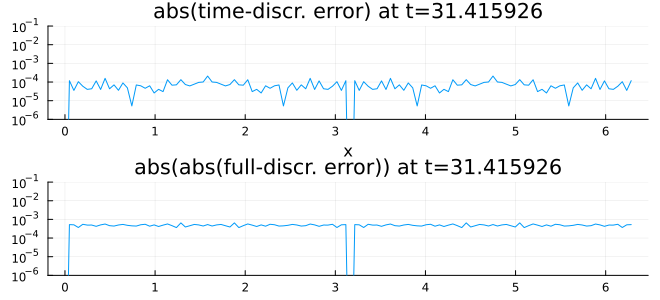

In [200]:

W_end_1= solDP5_1[end]
W_end_2 = solDP5_2[end]
W_end_ = solDP5_[end]
U_end_1 = expA(W_end_1,theta,p) 
U_end_2 = expA(W_end_2,theta,p)  
U_end_ = expA(W_end_,theta,p_)  

errU_t = U_end_1 - U_end_2 .+ eps()


xx = range(0,stop=2pi,length=J2)
yrange = (1e-6,1e-1)

pl_err_t = plot(xx,abs.(errU_t),yscale=:log10, ylims = yrange, xlabel="x",
                legend=false, title="abs(time-discr. error) at t=$(Float32(t_end))")

errU = U_end_1 - U_end_[1:2:end] .+ eps()

pl_err = plot(xx,abs.(errU), yscale=:log10, ylims = yrange, 
              legend=false, title="abs(abs(full-discr. error)) at t=$(Float32(t_end))")

plot(pl_err_t, pl_err,  layout=(2,1), size=(660,300))

L2-norm of the two type of errors:

In [201]:
(norm(errU_t)/sqrt(2J), norm(errU)/sqrt(2J))

(8.116217271307028e-5, 0.00048564727221074176)

Clearly, for the considered spatial semi-diskretization, it does not make much sense to use a tighter tolerance for the time-discretization.

## Numerical solution with Taylor-Fourier

In [206]:
#  M = 4J # (a)
#  deg = 3
 M = 32J # (b)
 deg = 4
#M = 64J # (c)
# deg = 3

tf_cache = NLS_ODE_TF_cache_init(W0,omega,deg,M)

prob_TF = PeriodicODEProblem(NLS_ODE_TF!, tf_cache, W0, omega)

@time sol_TF = TaylorFourierSolve(prob_TF,deg,M);  

  0.465981 seconds (226 allocations: 352.020 MiB, 0.19% gc time)


  0.009803 seconds (1 allocation: 2.125 KiB)


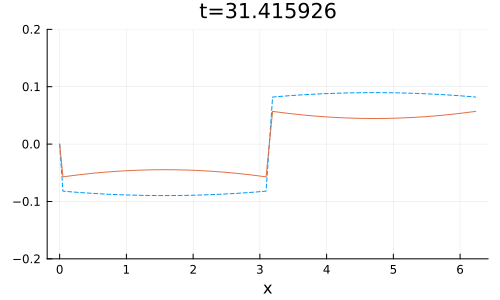

In [207]:
@time W_TF = sol_TF(t_end)
theta = p.omega*(t_end)
U_TF = expA(W_TF,theta,p)  


yrange=(-2epsilon,2epsilon)
xx = range(0,step=pi/J,length=J2)
plot(xlabel="x", title="t=$(Float32(t_end))", ylims=yrange, size=(500,300),legend=false)
plot!(xx,real(U_TF),label="real(u(t_end))",linestyle=:dash)
plot!(xx,imag(U_TF),label="imag(u(t_end))")

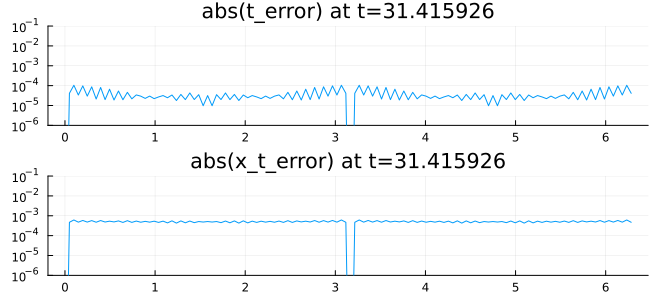

In [208]:
errU_t = U_TF - U_end_2 .+ eps()


xx = range(0,stop=2pi,length=J2)
yrange = (1e-6,1e-1)

pl_err_t = plot(xx,abs.(errU_t),yscale=:log10, ylims = yrange,
                legend=false, title="abs(t_error) at t=$(Float32(t_end))")

errU = U_TF - U_end_[1:2:end] .+ eps()

pl_err = plot(xx,abs.(errU), yscale=:log10, ylims = yrange, 
              legend=false, title="abs(x_t_error) at t=$(Float32(t_end))")

plot(pl_err_t, pl_err,  layout=(2,1), size=(660,300))

In [209]:
(norm(errU_t)/sqrt(2J), norm(errU)/sqrt(2J))

(4.442064590737132e-5, 0.0005067439848068806)

We get similar precision with both methods.

Let us now compare the CPU time of each integration:

In [210]:
@btime solve(prob,DP5(),abstol=tol_1,reltol=tol_1,save_everystep=false);

  136.826 ms (69 allocations: 38.34 KiB)


In [211]:
@btime TaylorFourierSolve(prob_TF,deg,M);

  453.083 ms (226 allocations: 352.02 MiB)


Our Taylor-Fourier integration gives, compared to the DP5-Lawson method, similar precision, but requires much more CPU time. 

In [92]:
49/15

3.2666666666666666